In [36]:
import pandas as pd
df = pd.read_excel('Volve production data.xlsx')

In [37]:
columns_to_fill = [
    'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
    'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P',
    'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']
for column in columns_to_fill:
    df[column] = df[column].ffill()

In [38]:
to_drop = ["WELL_BORE_CODE", "NPD_WELL_BORE_NAME", "NPD_FIELD_NAME", "NPD_FIELD_CODE", "NPD_FACILITY_CODE", "NPD_FACILITY_NAME","BORE_WI_VOL","AVG_CHOKE_UOM","FLOW_KIND","WELL_TYPE","BORE_OIL_VOL","BORE_GAS_VOL","BORE_WAT_VOL"]
modelonew = df.drop(to_drop, axis=1)
print(modelonew.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15634 entries, 0 to 15633
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATEPRD                   15634 non-null  datetime64[ns]
 1   NPD_WELL_BORE_CODE        15634 non-null  int64         
 2   ON_STREAM_HRS             15634 non-null  float64       
 3   AVG_DOWNHOLE_PRESSURE     15634 non-null  float64       
 4   AVG_DOWNHOLE_TEMPERATURE  15634 non-null  float64       
 5   AVG_DP_TUBING             15634 non-null  float64       
 6   AVG_ANNULUS_PRESS         15634 non-null  float64       
 7   AVG_CHOKE_SIZE_P          15634 non-null  float64       
 8   AVG_WHP_P                 15634 non-null  float64       
 9   AVG_WHT_P                 15634 non-null  float64       
 10  DP_CHOKE_SIZE             15634 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 1.3 MB
None


In [39]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from  xgboost import XGBRegressor
import xgboost as xgb


In [42]:
modelonew.reset_index(drop=True, inplace=True)
fdf = modelonew.loc[4970:8000]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Escalar tus características si es necesario
#scaler = MinMaxScaler(feature_range=(0, 1))
#X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']] = scaler.fit_transform(X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']])

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=4)
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    modelXGB= XGBRegressor()
    modelXGB.fit(x_train_final,y_train_final)
     #Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = modelXGB.predict(x_train_final)
    test_predictions = modelXGB.predict(x_test_final)

# Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

    # Convertir las listas de métricas en un DataFrame
metrics_df = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


In [43]:
metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,0.003294,0.057390,0.033810,1.000000,282.062296,16.794710,14.150447,0.721967
1,0.014890,0.122026,0.084179,0.999998,75.325660,8.679036,6.588794,0.860817
2,0.031497,0.177475,0.117875,0.999993,186.297070,13.649068,11.563387,0.410042
3,0.060314,0.245590,0.169812,0.999984,66.167343,8.134331,5.651036,0.978011


In [44]:
avg_metrics=metrics_df.mean()
# Calcular el promedio de las métricas
import pandas as pd
# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,0.027499,0.15062,0.101419,0.999994,152.463092,11.814286,9.488416,0.742709


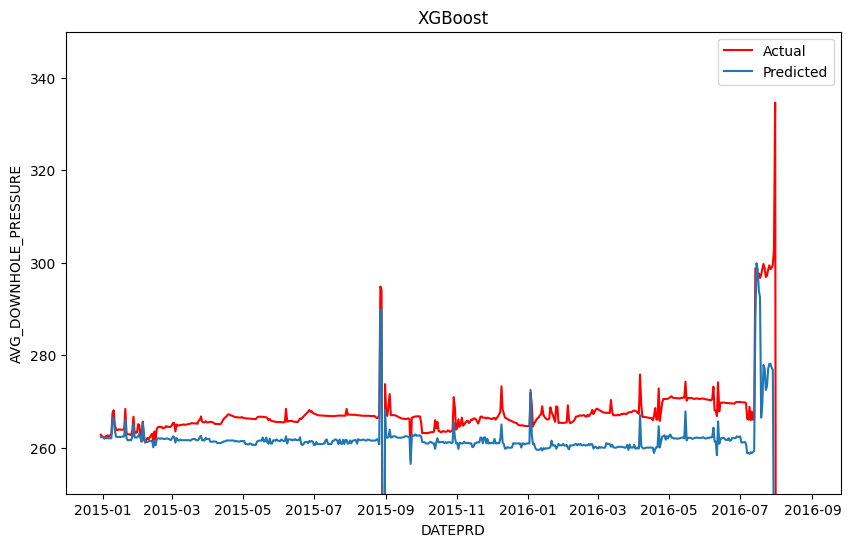

In [49]:
from matplotlib import pyplot as plt
# Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

    # Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_df = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', color='red')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted')
plt.title('XGBoost')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.ylim(250, 350)
plt.legend()
plt.show()

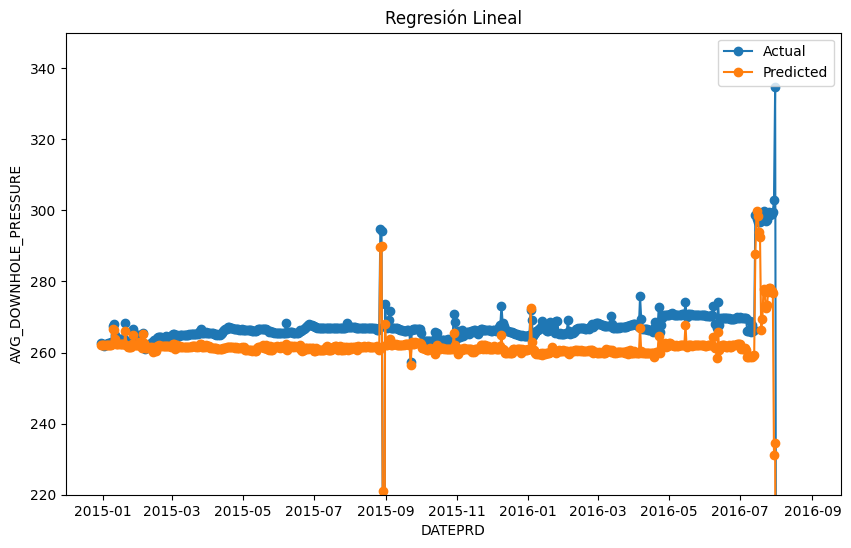

In [9]:
from matplotlib import pyplot as plt

# Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

# Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_df = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], 'o-', label='Actual')
plt.plot(results_df['Date'], results_df['Predicted'], 'o-', label='Predicted')
plt.title('Regresión Lineal')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.ylim(220, 350)  # Establecer el rango del eje Y
plt.legend()
plt.show()


**Decesion Tree**

In [10]:

from sklearn.tree import DecisionTreeRegressor
modelonew.reset_index(drop=True, inplace=True)
fdf = modelonew.loc[4969:8000]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Escalar tus características si es necesario
#scaler = MinMaxScaler(feature_range=(0, 1))
#X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']] = scaler.fit_transform(X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']])

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=4)
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    dec = DecisionTreeRegressor()
    dec.fit(x_train_final,y_train_final)
     #Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = dec.predict(x_train_final)
    test_predictions = dec.predict(x_test_final)

# Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse,train_rmse,train_mae,train_r2))
    test_scores.append((test_mse,test_rmse,test_mae,test_r2))

    # Convertir las listas de métricas en un DataFram
    metrics_df = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


In [11]:
metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,0.0,0.0,0.0,1.0,420.011265,20.494176,17.337927,0.585989
1,0.0,0.0,0.0,1.0,103.444561,10.170770,6.811986,0.808860
2,0.0,0.0,0.0,1.0,118.734674,10.896544,8.767182,0.623996
3,0.0,0.0,0.0,1.0,74.918970,8.655574,5.765442,0.975103


**Random Forest**

In [50]:

from sklearn.tree import DecisionTreeRegressor
modelonew.reset_index(drop=True, inplace=True)
fdf = modelonew.loc[4969:8000]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Escalar tus características si es necesario
#scaler = MinMaxScaler(feature_range=(0, 1))
#X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']] = scaler.fit_transform(X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']])

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=4)
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    from sklearn.ensemble import RandomForestRegressor
    modeloran=RandomForestRegressor(n_estimators=10,random_state=19)
    modeloran.fit(x_train_final,y_train_final)
     #Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = modeloran.predict(x_train_final)
    test_predictions = modeloran.predict(x_test_final)

# Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

    # Convertir las listas de métricas en un DataFrame
metrics_df = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


In [51]:
metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,7.125139,2.669296,0.638589,0.999308,140.532319,11.854633,8.452391,0.861475
1,4.579229,2.139913,0.525287,0.999305,76.379472,8.739535,6.236331,0.858869
2,2.505637,1.582920,0.479003,0.999477,154.383332,12.425109,10.523338,0.511105
3,2.390946,1.546268,0.364469,0.999382,63.322225,7.957526,5.674917,0.978957


In [52]:
avg_metrics=metrics_df.mean()
# Calcular el promedio de las métricas
import pandas as pd
# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,4.150238,1.984599,0.501837,0.999368,108.654337,10.244201,7.721744,0.802602


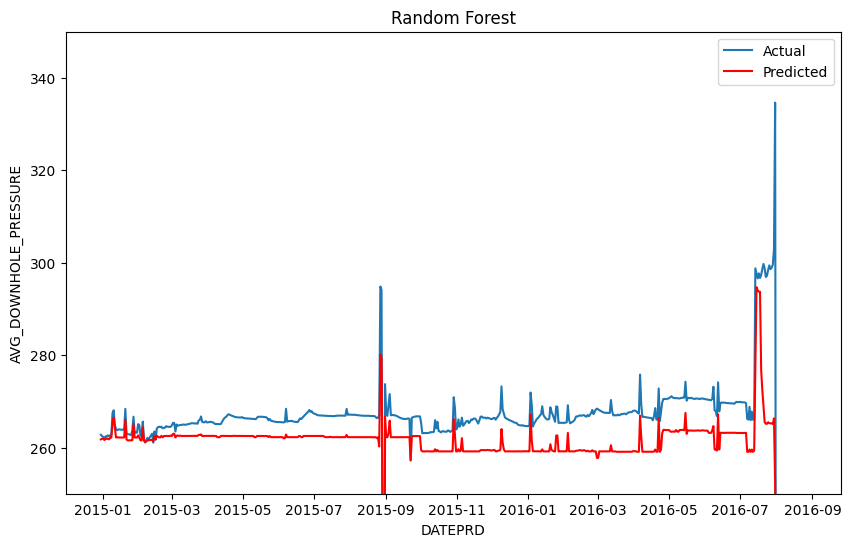

In [55]:
from matplotlib import pyplot as plt
# Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

    # Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_df = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted',color='red')
plt.title('Random Forest')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.ylim(250, 350)
plt.legend()
plt.show()

**Gradient Tree Boosting**



In [56]:
from sklearn.model_selection import TimeSeriesSplit
modelonew.reset_index(drop=True, inplace=True)
fdf = modelonew.loc[4969:8000]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Escalar tus características si es necesario
#scaler = MinMaxScaler(feature_range=(0, 1))
#X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']] = scaler.fit_transform(X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']])

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=4)
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    from sklearn.ensemble import GradientBoostingRegressor
# Inicializar el modelo de Gradient Boosting    Regressor
    modelogra = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
     #Hacer predicciones en los conjuntos de entrenamiento y de prueba
     # Entrenar el modelo
    modelogra.fit(x_train_final, y_train_final)
    train_predictions = modelogra.predict(x_train_final)
    test_predictions = modelogra.predict(x_test_final)

# Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

    # Convertir las listas de métricas en un DataFrame
metrics_df = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


In [57]:
metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,1.132531,1.064205,0.651963,0.999890,218.520776,14.782448,12.146813,0.784601
1,1.908050,1.381322,0.912545,0.999711,63.220793,7.951150,6.202872,0.883183
2,3.783423,1.945102,1.211444,0.999210,193.006958,13.892694,12.273628,0.388793
3,3.502994,1.871629,1.183381,0.999094,39.629853,6.295225,5.140611,0.986830


In [58]:
avg_metrics=metrics_df.mean()
# Calcular el promedio de las métricas
import pandas as pd
# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,2.58175,1.565564,0.989834,0.999476,128.594595,10.730379,8.940981,0.760852


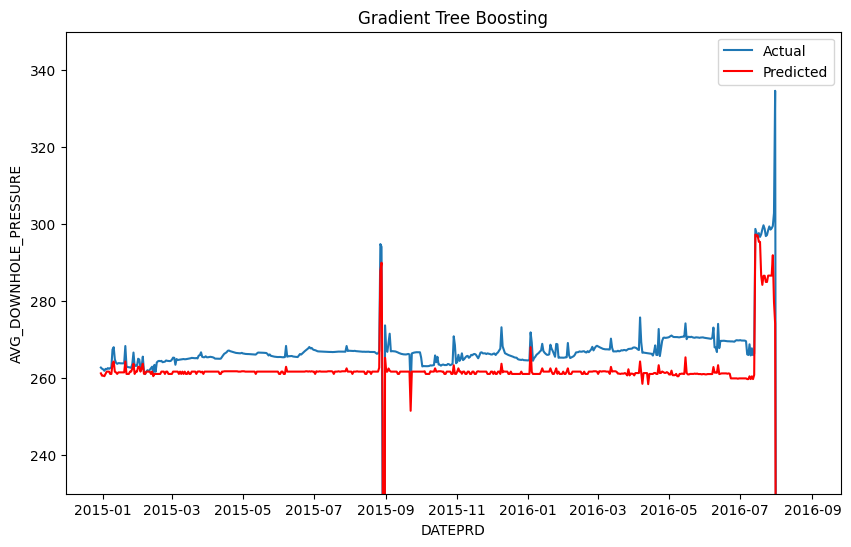

In [62]:
from matplotlib import pyplot as plt

# Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

# Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_df = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted',color='red')
plt.title('Gradient Tree Boosting')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.ylim(230, 350)  # Establecer el rango del eje Y
plt.legend()
plt.show()


**K-Nearest Neighbors (KNN)***

In [30]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
modelonew.reset_index(drop=True, inplace=True)
fdf = modelonew.loc[4969:8000]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Escalar tus características si es necesario
#scaler = MinMaxScaler(feature_range=(0, 1))
#X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']] = scaler.fit_transform(X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']])

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=4)
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']


# Inicializar el modelo de Gradient Boosting    Regressor
     #Replace GradientBoostingRegressor with KNeighborsRegressor
    modelknn = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors as needed

     #Hacer predicciones en los conjuntos de entrenamiento y de prueba
     # Entrenar el modelo
    modelknn.fit(x_train_final, y_train_final)
    # Train the model

    train_predictions = modelknn.predict(x_train_final)
    test_predictions = modelknn.predict(x_test_final)

# Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

    # Convertir las listas de métricas en un DataFrame
metrics_df = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


In [31]:
metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,8.584391,2.929913,1.047816,0.999166,357.618315,18.910799,16.890745,0.647491
1,6.783981,2.604608,0.887892,0.998971,111.988924,10.582482,7.809997,0.793072
2,5.447650,2.334020,0.801775,0.998862,176.477117,13.284469,11.334809,0.441139
3,4.714094,2.171197,0.738615,0.998781,30.619544,5.533493,4.450231,0.989825


In [32]:
avg_metrics=metrics_df.mean()
# Calcular el promedio de las métricas
import pandas as pd
# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,6.382529,2.509934,0.869024,0.998945,169.175975,12.077811,10.121445,0.717882


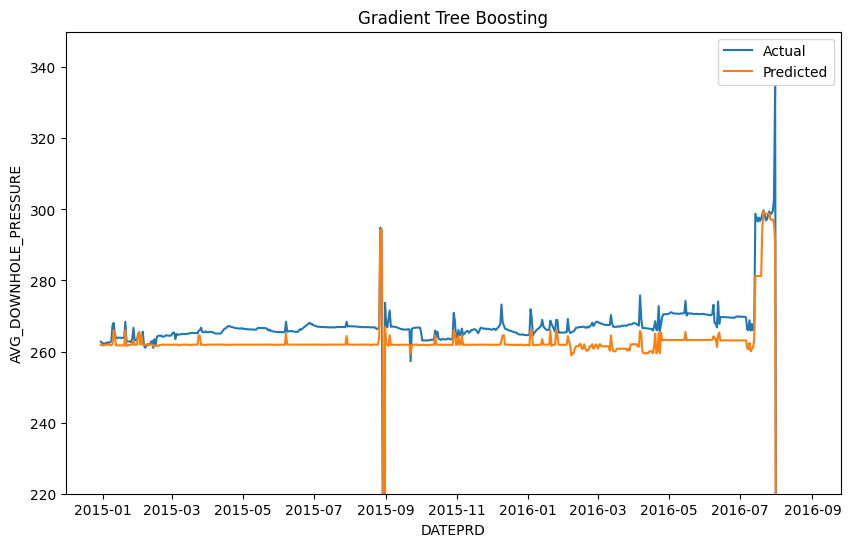

In [33]:
from matplotlib import pyplot as plt

# Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

# Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_df = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted')
plt.title('Gradient Tree Boosting')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.ylim(220, 350)  # Establecer el rango del eje Y
plt.legend()
plt.show()
